#### **Load dependencies**

In [2]:
!git clone https://github.com/nilmtk/nilm_metadata.git nilm_metadata-master
!git clone https://github.com/nilmtk/nilmtk.git nilmtk-master
!unzip neuralnilm.zip

!python nilm_metadata-master/setup.py develop
!python nilmtk-master/setup.py develop

!cp -r nilm_metadata-master/nilm_metadata .
!cp -r nilmtk-master/nilmtk .

!rm -r nilm_metadata-master
!rm -r nilm_metadata.egg-info
!rm -r nilmtk-master
!rm -r nilmtk.egg-info

!wget https://data.ukedc.rl.ac.uk/browse/edc/efficiency/residential/EnergyConsumption/Domestic/UK-DALE-2017/UK-DALE-FULL-disaggregated/ukdale.h5.zip
!unzip ukdale.h5.zip
!rm -r ukdale.h5.zip

Archive:  nilm_metadata-master.zip
7ed4bab9062d04cb35c6b6000b451715dc5ab4af
   creating: nilm_metadata-master/
  inflating: nilm_metadata-master/.gitignore  
  inflating: nilm_metadata-master/LICENSE  
  inflating: nilm_metadata-master/README.md  
   creating: nilm_metadata-master/conda.recipe/
  inflating: nilm_metadata-master/conda.recipe/bld.bat  
  inflating: nilm_metadata-master/conda.recipe/build.sh  
  inflating: nilm_metadata-master/conda.recipe/meta.yaml  
   creating: nilm_metadata-master/docs/
  inflating: nilm_metadata-master/docs/Makefile  
  inflating: nilm_metadata-master/docs/make.bat  
   creating: nilm_metadata-master/docs/source/
  inflating: nilm_metadata-master/docs/source/central_metadata.rst  
  inflating: nilm_metadata-master/docs/source/circuit_no_metadata.svg  
  inflating: nilm_metadata-master/docs/source/conf.py  
  inflating: nilm_metadata-master/docs/source/dataset_metadata.rst  
  inflating: nilm_metadata-master/docs/source/index.rst  
  inflating: nilm_m

In [29]:
import sys
import importlib
import tensorflow as tf
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(threshold=sys.maxsize)

from neuralnilm.data.datathread import DataThread
from neuralnilm.data.loadactivations import load_nilmtk_activations
from neuralnilm.data.realaggregatesource import RealAggregateSource
from neuralnilm.data.datapipeline import DataPipeline
from neuralnilm.consts import DATA_FOLD_NAMES

#### **Data loader**

In [88]:
SELECTED_APPLIANCE = 'fridge'
NILMTK_FILENAME = './ukdale.h5'
SAMPLE_PERIOD = 6
APPLIANCES = ['kettle', 'microwave', 'washing machine', 'fridge']
WINDOWS = {
    'train': {
        1: ("2013-04-12", "2015-07-01"),
        2: ("2013-05-22", "2013-10-03 06:16:00"),
        3: ("2013-02-27", "2013-04-01 06:15:05"),
        4: ("2013-03-09", "2013-09-24 06:15:14")
    },
    'unseen_activations_of_seen_appliances': {
        1: ("2015-07-02", None),
        2: ("2013-10-03 06:16:00", None),
        3: ("2013-04-01 06:15:05", None),
        4: ("2013-09-24 06:15:14", None)
    },
    'unseen_appliances': {
        5: ("2014-06-29", None)
    }
}

# ------------------------ DATA ----------------------

def get_pipeline(target_appliance, activations):
    num_seq_per_batch = 1
    if target_appliance == 'kettle':
        seq_length = 128*64
        train_buildings = [1, 2, 4]
        unseen_buildings = [5]
    elif target_appliance == 'microwave':
        seq_length = 14400
        train_buildings = [1, 2, 4]
        unseen_buildings = [5]
    elif target_appliance == 'washing machine':
        seq_length = 1024*8
        train_buildings = [1, 2, 4]
        unseen_buildings = [5]
    elif target_appliance == 'fridge':
        seq_length = 512
        train_buildings = [1, 2, 4]
        unseen_buildings = [5]
    elif target_appliance == 'dish washer':
        seq_length = 1024 + 512
        train_buildings = [1, 2, 4]
        unseen_buildings = [5]

    filtered_windows = select_windows(train_buildings, unseen_buildings)
    filtered_activations = filter_activations(filtered_windows, activations)

    real_agg_source = RealAggregateSource(
        activations=filtered_activations,
        target_appliance=target_appliance,
        seq_length=seq_length,
        filename=NILMTK_FILENAME,
        windows=filtered_windows,
        sample_period=SAMPLE_PERIOD,
        allow_multiple_target_activations_in_aggregate=True,
        include_multiple_targets_in_output=True
    )

    pipeline = DataPipeline(
        [real_agg_source],
        num_seq_per_batch=num_seq_per_batch,
        input_processing=[],
        target_processing=[]
    )


    return pipeline


def select_windows(train_buildings, unseen_buildings):
    windows = {fold: {} for fold in DATA_FOLD_NAMES}

    def copy_window(fold, i):
        windows[fold][i] = WINDOWS[fold][i]

    for i in train_buildings:
        copy_window('train', i)
        copy_window('unseen_activations_of_seen_appliances', i)
    for i in unseen_buildings:
        copy_window('unseen_appliances', i)
    return windows


def filter_activations(windows, activations):
    new_activations = {
        fold: {appliance: {} for appliance in APPLIANCES}
        for fold in DATA_FOLD_NAMES}
    for fold, appliances in list(activations.items()):
        for appliance, buildings in list(appliances.items()):
            required_building_ids = list(windows[fold].keys())
            required_building_names = [
                'UK-DALE_building_{}'.format(i) for i in required_building_ids]
            for building_name in required_building_names:
                try:
                    new_activations[fold][appliance][building_name] = (
                        activations[fold][appliance][building_name])
                except KeyError:
                    pass
    return new_activations


activations = load_nilmtk_activations(
    appliances=APPLIANCES,
    filename=NILMTK_FILENAME,
    sample_period=SAMPLE_PERIOD,
    windows=WINDOWS
)

pipeline = get_pipeline(SELECTED_APPLIANCE, activations)

data_thread = DataThread(pipeline)
data_thread.start()

/content/nilmtk/utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")
/content/nilmtk/utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")
/content/neuralnilm/data/realaggregatesource.py:258: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  seq.target = seq.target[:, np.newaxis]


In [89]:
train_data_groups = []
val_data_groups = []
test_data_groups = []

while len(train_data_groups) < 64:
    try:
        group = pipeline.get_batch(fold='train')
        if group:
            train_data_groups.append(group)
    except Exception:
        pass

while len(val_data_groups) < 16:
    try:
        group = pipeline.get_batch(fold='unseen_activations_of_seen_appliances')
        if group:
            val_data_groups.append(group)
    except Exception:
        pass

while len(test_data_groups) < 24:
    try:
        group = pipeline.get_batch(fold='unseen_appliances')
        if group:
            test_data_groups.append(group)
    except Exception:
        pass

train_x = np.concatenate([v.input for v in train_data_groups]).flatten()
train_y = np.concatenate([v.target for v in train_data_groups]).flatten()

val_x = np.concatenate([v.input for v in val_data_groups]).flatten()
val_y = np.concatenate([v.target for v in val_data_groups]).flatten()

test_x = np.concatenate([v.input for v in test_data_groups]).flatten()[:90000]
test_y = np.concatenate([v.target for v in test_data_groups]).flatten()[:90000]

Text(0.5, 1.0, 'example data kettle')

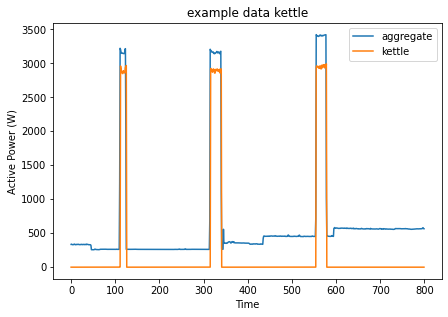

In [21]:
plt.figure(figsize=(32, 16))

train_selected = slice(11000, 11800)
plt.subplot(3, 4, 1)
plt.plot(train_x[train_selected], label="aggregate")
plt.plot(train_y[train_selected], label=SELECTED_APPLIANCE)
plt.xlabel("Time")
plt.ylabel("Active Power (W)")
plt.legend()
plt.title("example data " + SELECTED_APPLIANCE)

#### Utils

In [69]:
def mae(prediction, true):
    MAE = abs(true - prediction)
    MAE = np.sum(MAE)
    MAE = MAE / len(prediction)
    return MAE


def sae(prediction, true, N):
    T = len(prediction)
    K = int(T / N)
    SAE = 0
    for k in range(1, N):
        pred_r = np.sum(prediction[k * N: (k + 1) * N])
        true_r = np.sum(true[k * N: (k + 1) * N])
        SAE += abs(true_r - pred_r)
    SAE = SAE / (K * N)
    return SAE


def f1(prediction, true):
    epsilon = 1e-8
    TP = epsilon
    FN = epsilon
    FP = epsilon
    TN = epsilon
    for i in range(len(prediction)):
        if prediction[i] >= 0.5:
            prediction_binary = 1
        else:
            prediction_binary = 0
        if prediction_binary == 1 and true[i] == 1:
            TP += 1
        elif prediction_binary == 0 and true[i] == 1:
            FN += 1
        elif prediction_binary == 1 and true[i] == 0:
            FP += 1
        elif prediction_binary == 0 and true[i] == 0:
            TN += 1
    R = TP / (TP + FN)
    P = TP / (TP + FP)
    f1 = (2 * P * R) / (P + R)
    return f1


def standardize_data(data, mu=0.0, sigma=1.0):
    data -= mu
    data /= sigma
    return data


def normalize_data(data, min_value=0.0, max_value=1.0):
    data -= min_value
    data /= max_value - min_value
    return data


def build_overall_sequence(sequences):
    unique_sequence = []
    matrix = [sequences[::-1, :].diagonal(i) for i in range(-sequences.shape[0] + 1, sequences.shape[1])]
    for i in range(len(matrix)):
        unique_sequence.append(np.median(matrix[i]))
    unique_sequence = np.array(unique_sequence)
    return unique_sequence


#### Data generator

In [31]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, size, mains, appliances_regression, appliances_classification, window_size, batch_size, shuffle=False):
        self.curr_pos = 1
        self.size = size if size is not None else len(mains)

        self.mains = mains
        self.appliances_regression = appliances_regression
        self.appliances_classification = appliances_classification

        self._mains = self.mains[(self.curr_pos - 1) * self.size : self.curr_pos * self.size]
        self._appliances_regression = self.appliances_regression[(self.curr_pos - 1) * self.size : self.curr_pos * self.size]
        self._appliances_classification = self.appliances_classification[(self.curr_pos - 1) * self.size : self.curr_pos * self.size]

        self.window_size = window_size
        self.batch_size = batch_size
        self.indices = np.arange(len(self._mains) - self.window_size + 1)
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        mains_batch = []
        appliances_regression_batch = []
        appliances_classification_batch = []
        appliance_regression_sample = []
        appliance_classification_sample = []

        if idx == self.__len__() - 1:
            inds = self.indices[idx * self.batch_size:]
        else:
            inds = self.indices[idx * self.batch_size: (idx + 1) * self.batch_size]

        for i in inds:
            main_sample = self._mains[i:i + self.window_size]
            appliance_regression_sample = self._appliances_regression[i:i + self.window_size]
            appliance_classification_sample = self._appliances_classification[i:i + self.window_size]

            mains_batch.append(main_sample)
            appliances_regression_batch.append(appliance_regression_sample)
            appliances_classification_batch.append(appliance_classification_sample)

        mains_batch_np = np.array(mains_batch)
        mains_batch_np = np.reshape(mains_batch_np, (mains_batch_np.shape[0], mains_batch_np.shape[1], 1))
        appliances_regression_batch_np = np.array(appliances_regression_batch)
        appliances_regression_batch_np = np.reshape(appliances_regression_batch_np,
                                                    (appliances_regression_batch_np.shape[0],
                                                     appliances_regression_batch_np.shape[1]))
        appliances_classification_batch_np = np.array(appliances_classification_batch)
        appliances_classification_batch_np = np.reshape(appliances_classification_batch_np,
                                                        (appliances_classification_batch_np.shape[0],
                                                         appliances_classification_batch_np.shape[1]))
        return mains_batch_np, [appliances_regression_batch_np, appliances_classification_batch_np]

    def on_epoch_end(self):
        self.curr_pos += 1 if (self.curr_pos + 1) * self.size < len(self.mains) else 0

        self._mains = self.mains[(self.curr_pos - 1) * self.size : self.curr_pos * self.size]
        self._appliances_regression = self.appliances_regression[(self.curr_pos - 1) * self.size : self.curr_pos * self.size]
        self._appliances_classification = self.appliances_classification[(self.curr_pos - 1) * self.size : self.curr_pos * self.size]

        if self.shuffle:
            np.random.shuffle(self.indices)

#### Model

In [24]:
class AttentionLayer(tf.keras.Model):

    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        weight_initializer = 'he_normal'
        self.W = tf.keras.layers.Dense(units, kernel_initializer=weight_initializer)
        self.V = tf.keras.layers.Dense(1, kernel_initializer=weight_initializer)

    def call(self, encoder_output, **kwargs):
        # encoder_output shape == (batch_size, seq_length, latent_dim)
        # score shape == (batch_size, seq_length, 1)
        score = self.V(tf.nn.tanh(self.W(encoder_output)))

        # attention_weights shape == (batch_size, seq_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


def build_model(window_size, filters, kernel_size, units, name):
    input_data = tf.keras.Input(shape=(window_size, 1))

    # CLASSIFICATION SUBNETWORK
    x = tf.keras.layers.Conv1D(filters=30, kernel_size=10, activation='relu')(input_data)
    x = tf.keras.layers.Conv1D(filters=30, kernel_size=8, activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=40, kernel_size=6, activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=50, kernel_size=5, activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=50, kernel_size=5, activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=50, kernel_size=5, activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units=1024, activation='relu', kernel_initializer='he_normal')(x)
    classification_output = tf.keras.layers.Dense(units=window_size, activation='sigmoid', name="classification_output")(x)

    #REGRESSION SUBNETWORK
    y = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(input_data)
    y = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(y)
    y = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(y)
    y = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(y)
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, activation="tanh", return_sequences=True), merge_mode="concat")(y)
    y, weights = AttentionLayer(units=units)(y)
    y = tf.keras.layers.Dense(units, activation='relu')(y)
    regression_output = tf.keras.layers.Dense(window_size, activation='relu', name="regression_output")(y)

    output = tf.keras.layers.Multiply(name="output")([regression_output, classification_output])

    full_model = tf.keras.Model(inputs=input_data, outputs=[output, classification_output], name=name)
    attention_model = tf.keras.Model(inputs=input_data, outputs=weights)

    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.01,
                                                                 decay_steps=28122,
                                                                 decay_rate=0.0001,
                                                                 staircase=False)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    full_model.compile(optimizer=optimizer, loss={
        "output": tf.keras.losses.MeanSquaredError(),
        "classification_output": tf.keras.losses.BinaryCrossentropy()})

    return full_model, attention_model

### **Training**

In [ ]:
main_train, appliance_train = np.copy(train_x), np.copy(train_y)
main_val, appliance_val = np.copy(val_x), np.copy(val_y)

# Choose the appliance-specific window size
window_size = 288

# Threshold of 15 Watt for detecting the ON/OFF states
THRESHOLD = 15

# Build ON/OFF appliance vector for the classification subtask
appliance_train_classification = np.copy(appliance_train)
appliance_train_classification[appliance_train_classification <= THRESHOLD] = 0
appliance_train_classification[appliance_train_classification > THRESHOLD] = 1

appliance_val_classification = np.copy(appliance_val)
appliance_val_classification[appliance_val_classification <= THRESHOLD] = 0
appliance_val_classification[appliance_val_classification > THRESHOLD] = 1

# Standardization of the main power and normalization of appliance power
appliance_min_power = np.min(appliance_train)
appliance_max_power = np.max(appliance_train)
main_std = np.std(main_train)
main_mean = np.mean(main_train)

main_train = standardize_data(main_train, np.mean(main_train), np.std(main_train))
main_val = standardize_data(main_val, np.mean(main_val), np.std(main_val))

appliance_train_regression = np.copy(appliance_train)
appliance_train_regression = normalize_data(appliance_train_regression, appliance_min_power, appliance_max_power)

appliance_val_regression = np.copy(appliance_val)
appliance_val_regression = normalize_data(appliance_val_regression, appliance_min_power, appliance_max_power)

# Data generator
batch_size = 32
train_sample_count_per_epoch = 10**6
val_sample_count_per_epoch = 8**5

train_generator = DataGenerator(train_sample_count_per_epoch, main_train, appliance_train_regression,
                                appliance_train_classification, window_size, batch_size)
val_generator = DataGenerator(val_sample_count_per_epoch, main_val, appliance_val_regression,
                              appliance_val_classification, window_size, batch_size)

# Tune the appliance-dependent parameters
filters = 32
kernel_size = 8
units = 512

model, att_model = build_model(window_size, filters, kernel_size, units, SELECTED_APPLIANCE)
model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./drive/MyDrive/fridge_tmp',
                                                         monitor='val_loss',
                                                         verbose=1,
                                                         save_best_only=True,
                                                         mode='auto',
                                                         save_freq='epoch')

history = model.fit(x=train_generator, epochs=100, steps_per_epoch=len(train_generator),
                    validation_data=val_generator, validation_steps=len(val_generator),
                    callbacks=[early_stop, checkpoint_callback], verbose=1)

#### **Evaluating** trained models

In [82]:
def showcase_model(model, test_x, test_y, window_size, area):
    model.summary()

    # run predictions on test data
    appliance_test_classification = np.copy(test_y)
    appliance_test_classification[appliance_test_classification <= THRESHOLD] = 0
    appliance_test_classification[appliance_test_classification > THRESHOLD] = 1

    appliance_min_power = np.min(appliance_train)
    appliance_max_power = np.max(appliance_train)

    main_test = standardize_data(np.copy(test_x), np.mean(test_x), np.std(test_x))

    appliance_test_regression = np.copy(test_y)
    appliance_test_regression = normalize_data(appliance_test_regression, appliance_min_power, appliance_max_power)

    batch_size = 32
    test_generator = DataGenerator(90000, main_test, appliance_test_regression,
                                  appliance_test_classification, window_size, batch_size)

    predicted_output, predicted_on_off = model.predict(x=test_generator, steps=len(test_generator))

    predicted_output *= (appliance_max_power - appliance_min_power)
    predicted_output += appliance_min_power

    predicted_output[predicted_output < 0] = 0.0

    prediction = build_overall_sequence(predicted_output)
    prediction_on_off = build_overall_sequence(predicted_on_off)
    
    # metrics
    MAE = mae(prediction, test_y)
    SAE = sae(prediction, test_y, N=1200)
    F1 = f1(prediction_on_off, appliance_test_classification)

    print(f'MAE: {MAE}')
    print(f'SAE: {SAE}')
    print(f'F1: {F1}')

    # some example predictions
    plt.figure(figsize=(32, 16))

    plt.subplot(3, 4, 1)
    plt.plot(test_x, label="aggregate", color='blue', alpha=0.5)
    plt.plot(test_y, label="ground truth", color='green')
    plt.plot(prediction, label="prediction", color='red', alpha=0.7)
    plt.xlabel("Time")
    plt.ylabel("Active Power (W)")
    plt.legend()
    plt.title("prediction for " + SELECTED_APPLIANCE)

    plt.subplot(3, 4, 2)
    plt.plot(test_x[area], label="aggregate", color='blue', alpha=0.5)
    plt.plot(test_y[area], label="ground truth", color='green')
    plt.plot(prediction[area], label="prediction", color='red', alpha=0.7)
    plt.xlabel("Time")
    plt.ylabel("Active Power (W)")
    plt.legend()
    plt.title("prediction for " + SELECTED_APPLIANCE + f"[{area.start}:{area.stop}]")

**Kettle**

Model: "LDwA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 1)]     0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 119, 30)      330         ['input_2[0][0]']                
                                                                                                  
 conv1d_16 (Conv1D)             (None, 121, 32)      288         ['input_2[0][0]']                
                                                                                                  
 conv1d_11 (Conv1D)             (None, 112, 30)      7230        ['conv1d_10[0][0]']              
                                                                                               

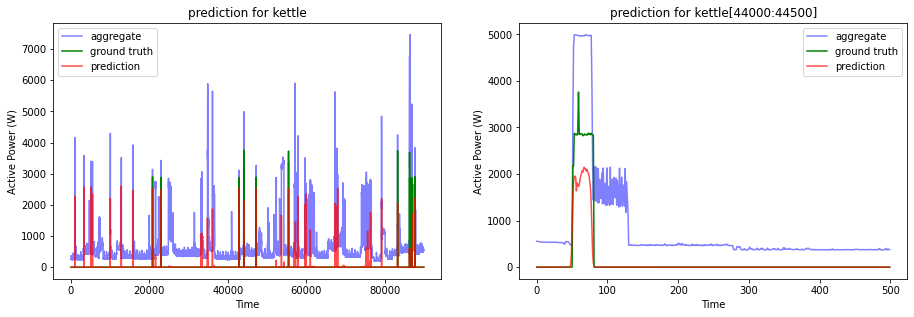

In [83]:
showcase_model(load_model("drive/MyDrive/new_kettle"), test_x, test_y, 128, slice(44000,44500))

Model: "LDwA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 1)]     0           []                               
                                                                                                  
 conv1d_40 (Conv1D)             (None, 503, 30)      330         ['input_5[0][0]']                
                                                                                                  
 conv1d_46 (Conv1D)             (None, 509, 16)      80          ['input_5[0][0]']                
                                                                                                  
 conv1d_41 (Conv1D)             (None, 496, 30)      7230        ['conv1d_40[0][0]']              
                                                                                               

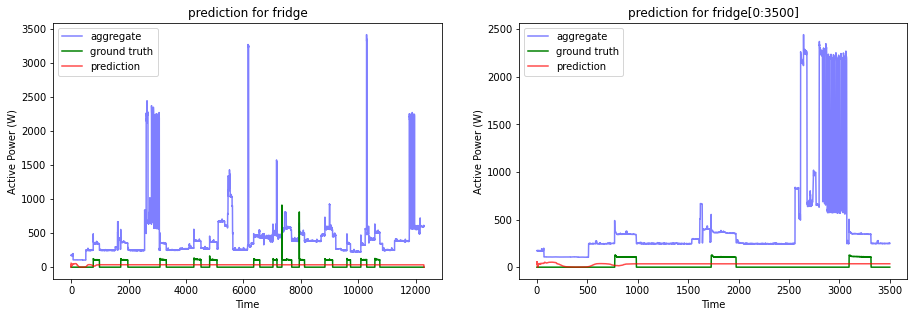

In [91]:
showcase_model(load_model("drive/MyDrive/new_fridge2"), test_x, test_y, 512, slice(0,3500))